# Sets iniciais do projeto.
Instalação de bibliotecas necessárias, imports e criação dos datasets de teste
| Data set | Classes | Dimension | Points |
|----------|---------|-----------|--------|
| g241c    | 2       | 241       | 1500   |
| g241d    | 2       | 241       | 1500   |
| Digit1   | 2       | 241       | 1500   |
| USPS     | 2       | 241       | 1500   |
| COIL     | 6       | 241       | 1500   |
| Text     | 2       | 11,960    | 1500   |


In [15]:
# Instalação das bibliotecas

# %pip install sslbookdata
# %pip install scikit-learn
# %pip install matplotlib
# %pip install networkx

In [16]:
# Importação das bibliotecas

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sslbookdata
import time
import pandas as pd
from Difusores import Utils, GRF, ActualState


In [17]:
# Upload dos datasets

datasets = {
    'USPS': sslbookdata.load_usps(0),
    'COIL': sslbookdata.load_coil2(0),
    'DIGIT': sslbookdata.load_digit1(0),
    'GC': sslbookdata.load_g241c(0),
    'GN': sslbookdata.load_g241n(0),
    # 'TEXT': sslbookdata.load_text(0)
}

# Quais serão os passos da construção desse trabalho?
1) Geração de um grafo a partir do dataset
2) Difusão dos rótulos a partir do grafo
3) Gerar uma análise dos resultados obtidos


# 1) Geração de um grafo a partir do dataset

O conceito abordado é a utilização dos dois primeiros passos do HDBSCAN* a fim de gerar uma árvore geradora mínima, esse é nosso objetivo

## Primeira etapa do HDBSCAN* - Computar core distance para todas instâncias do dataset em relação a um número mínimo de pontos

Conceito de Core Distance: Raio mínimo necessário para que uma instância qualquer X seja considerado um objeto core, tendo em vista um número mínimo de pontos próximos (incluindo o próprio ponto)

In [18]:
# Codigo que computa o core distance e retorna um array que contem os raios minimos 
# e as 3 instâncias que são as mais próximas de determinado ponto

def computeCoreDistance(datasetToComputeDistance, min_samples):
    list_de_raios_minimos = []
    list_de_indices_vizinhos = []
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(datasetToComputeDistance)

    distances, indices = neighbors.kneighbors(datasetToComputeDistance)
    for i in range(len(datasetToComputeDistance)):
        list_de_raios_minimos.append(distances[i, -1])
        list_de_indices_vizinhos.append(indices[i])
    return list_de_raios_minimos, list_de_indices_vizinhos

In [19]:
# Print dos raios minimos, das 3 instancias mais proximas de cada ponto 
# e o dataset em 2d com os 3 pontos mais próximos da primeira instâncias

def plotGraphAndStats(dataset_name, datasetForPlot, listOfNeighboringIndices, listOfMinimumRadius):
    plt.figure()
    for i in range(1, len(datasetForPlot)):
        plt.scatter(datasetForPlot[i, 0], datasetForPlot[i, 1], c='b', marker='o', s=8)
    for i in listOfNeighboringIndices[0]:
        plt.scatter(datasetForPlot[i, 0], datasetForPlot[i, 1], c='r', marker='o', s=8)
    plt.scatter(datasetForPlot[0, 0], datasetForPlot[0, 1], c='r', marker='x', s=32, label='Instância 1')
    print(f'Raio mínimo para instância 1 ser um core: {listOfMinimumRadius[0]}')
    print(f'Lista das intâncias mais perto da instância 1: {listOfNeighboringIndices[0]}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Instâncias do dataset {dataset_name}')
    plt.show()

Raio mínimo para instância 1 ser um core: 3.5340244364500677
Lista das intâncias mais perto da instância 1: [   0 1107  695]


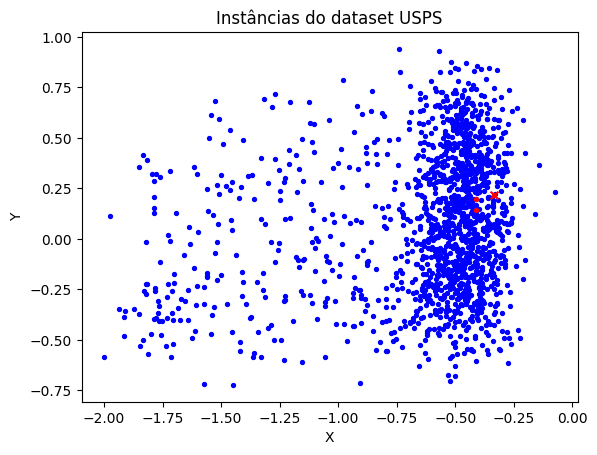

In [20]:
datasetTreino = datasets['USPS']['data']
numeroMinimoDePontos = 3
listaDeRaiosMinimos, listaDeIndicesVizinhos = computeCoreDistance(datasetTreino, numeroMinimoDePontos)
plotGraphAndStats('USPS', datasetTreino, listaDeIndicesVizinhos, listaDeRaiosMinimos)

## Segunda etapa do HDBSCAN* - Gerar uma árvore geradora mínima a partir do grafo de alcançabilidade mútua

Grafo de alcançabilidade mútua: grafo completo em que os pontos são os objetos do dataset e os pesos das areastas é a distância de alcançabilidade entre os pontos, dado os pontos x1 e x2 essa ditância é calculada pelo maior valor entre: CoreDistance(X1), CoreDistance(X2) e Distância(X1, X2)

In [21]:
# TEMOS QUE CRIAR UMA FUNÇÃO QUE CALCULA A DISTÂNCIA DE ALCANÇABILIDADE ENTRE DOIS PONTOS

def mutualReachabilityDistanceCalculation(datasetParaAlcancabilidade, printarDistancias=False):
    distancia_alcancabilidade_mutua = []
    for i in range(len(datasetParaAlcancabilidade)):
        alcancabilidade_mutua = []
        for j in range(len(datasetParaAlcancabilidade)):
            if i != j:
                distancia = np.linalg.norm(datasetParaAlcancabilidade[i] - datasetParaAlcancabilidade[j])
                reachability_distance = max(distancia, listaDeRaiosMinimos[j])
                alcancabilidade_mutua.append(reachability_distance)
        distancia_alcancabilidade_mutua.append(alcancabilidade_mutua)

    if printarDistancias:
        print("Distância de Alcançabilidade Mútua:")
        for i in range(len(distancia_alcancabilidade_mutua)):
            for j in range(len(distancia_alcancabilidade_mutua[i])):
                print(f"Ponto {i} para Ponto {j}: {distancia_alcancabilidade_mutua[i][j]}")
                
    return distancia_alcancabilidade_mutua

In [22]:
# Criação de um grafo de alcançabilidade mutua

def createReachabilityGraph(mutual_reachability_distance):
    G = nx.Graph()
    num_instancias = len(mutual_reachability_distance)
    G.add_nodes_from(range(num_instancias))
    for i in range(len(mutual_reachability_distance)):
        for j in range(len(mutual_reachability_distance[i])):
            peso = mutual_reachability_distance[i][j]
            G.add_edge(i, j, weight=peso)
    return G


In [23]:
def plotWeightedGraph(graphForPlot, alreadyWithLabels=False):
    if alreadyWithLabels:
        node_colors = ['blue' if graphForPlot.nodes[node]['label'] == 1 else 'red' for node in graphForPlot.nodes()]
        blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Label 1', markerfacecolor='blue', markersize=10)
        red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Label -1', markerfacecolor='red', markersize=10)
        plt.legend(handles=[blue_patch, red_patch])
    else:
        node_colors = 'lightblue'

    pos = nx.spring_layout(graphForPlot)
    labels = nx.get_edge_attributes(graphForPlot, 'weight')
    edge_labels = {e: f'{labels[e]:.2f}' for e in graphForPlot.edges}
    plt.figure(figsize=(20, 16))
    nx.draw(graphForPlot, pos, with_labels=False, node_size=40, node_color=node_colors, edge_color='green')
    nx.draw_networkx_edges(graphForPlot, pos)
    nx.draw_networkx_edge_labels(graphForPlot, pos, edge_labels=edge_labels, font_size=6)
    plt.title("Árvore Geradora Mínima")
    plt.show()

In [24]:
# Criação de uma árvore geradora minima a partir de um grafo

def createMinimumSpanningTree(baseGraph, printGraph=False):
    minimum_spanning_tree = nx.minimum_spanning_tree(baseGraph)
    if printGraph:
        plotWeightedGraph(minimum_spanning_tree)
    return minimum_spanning_tree


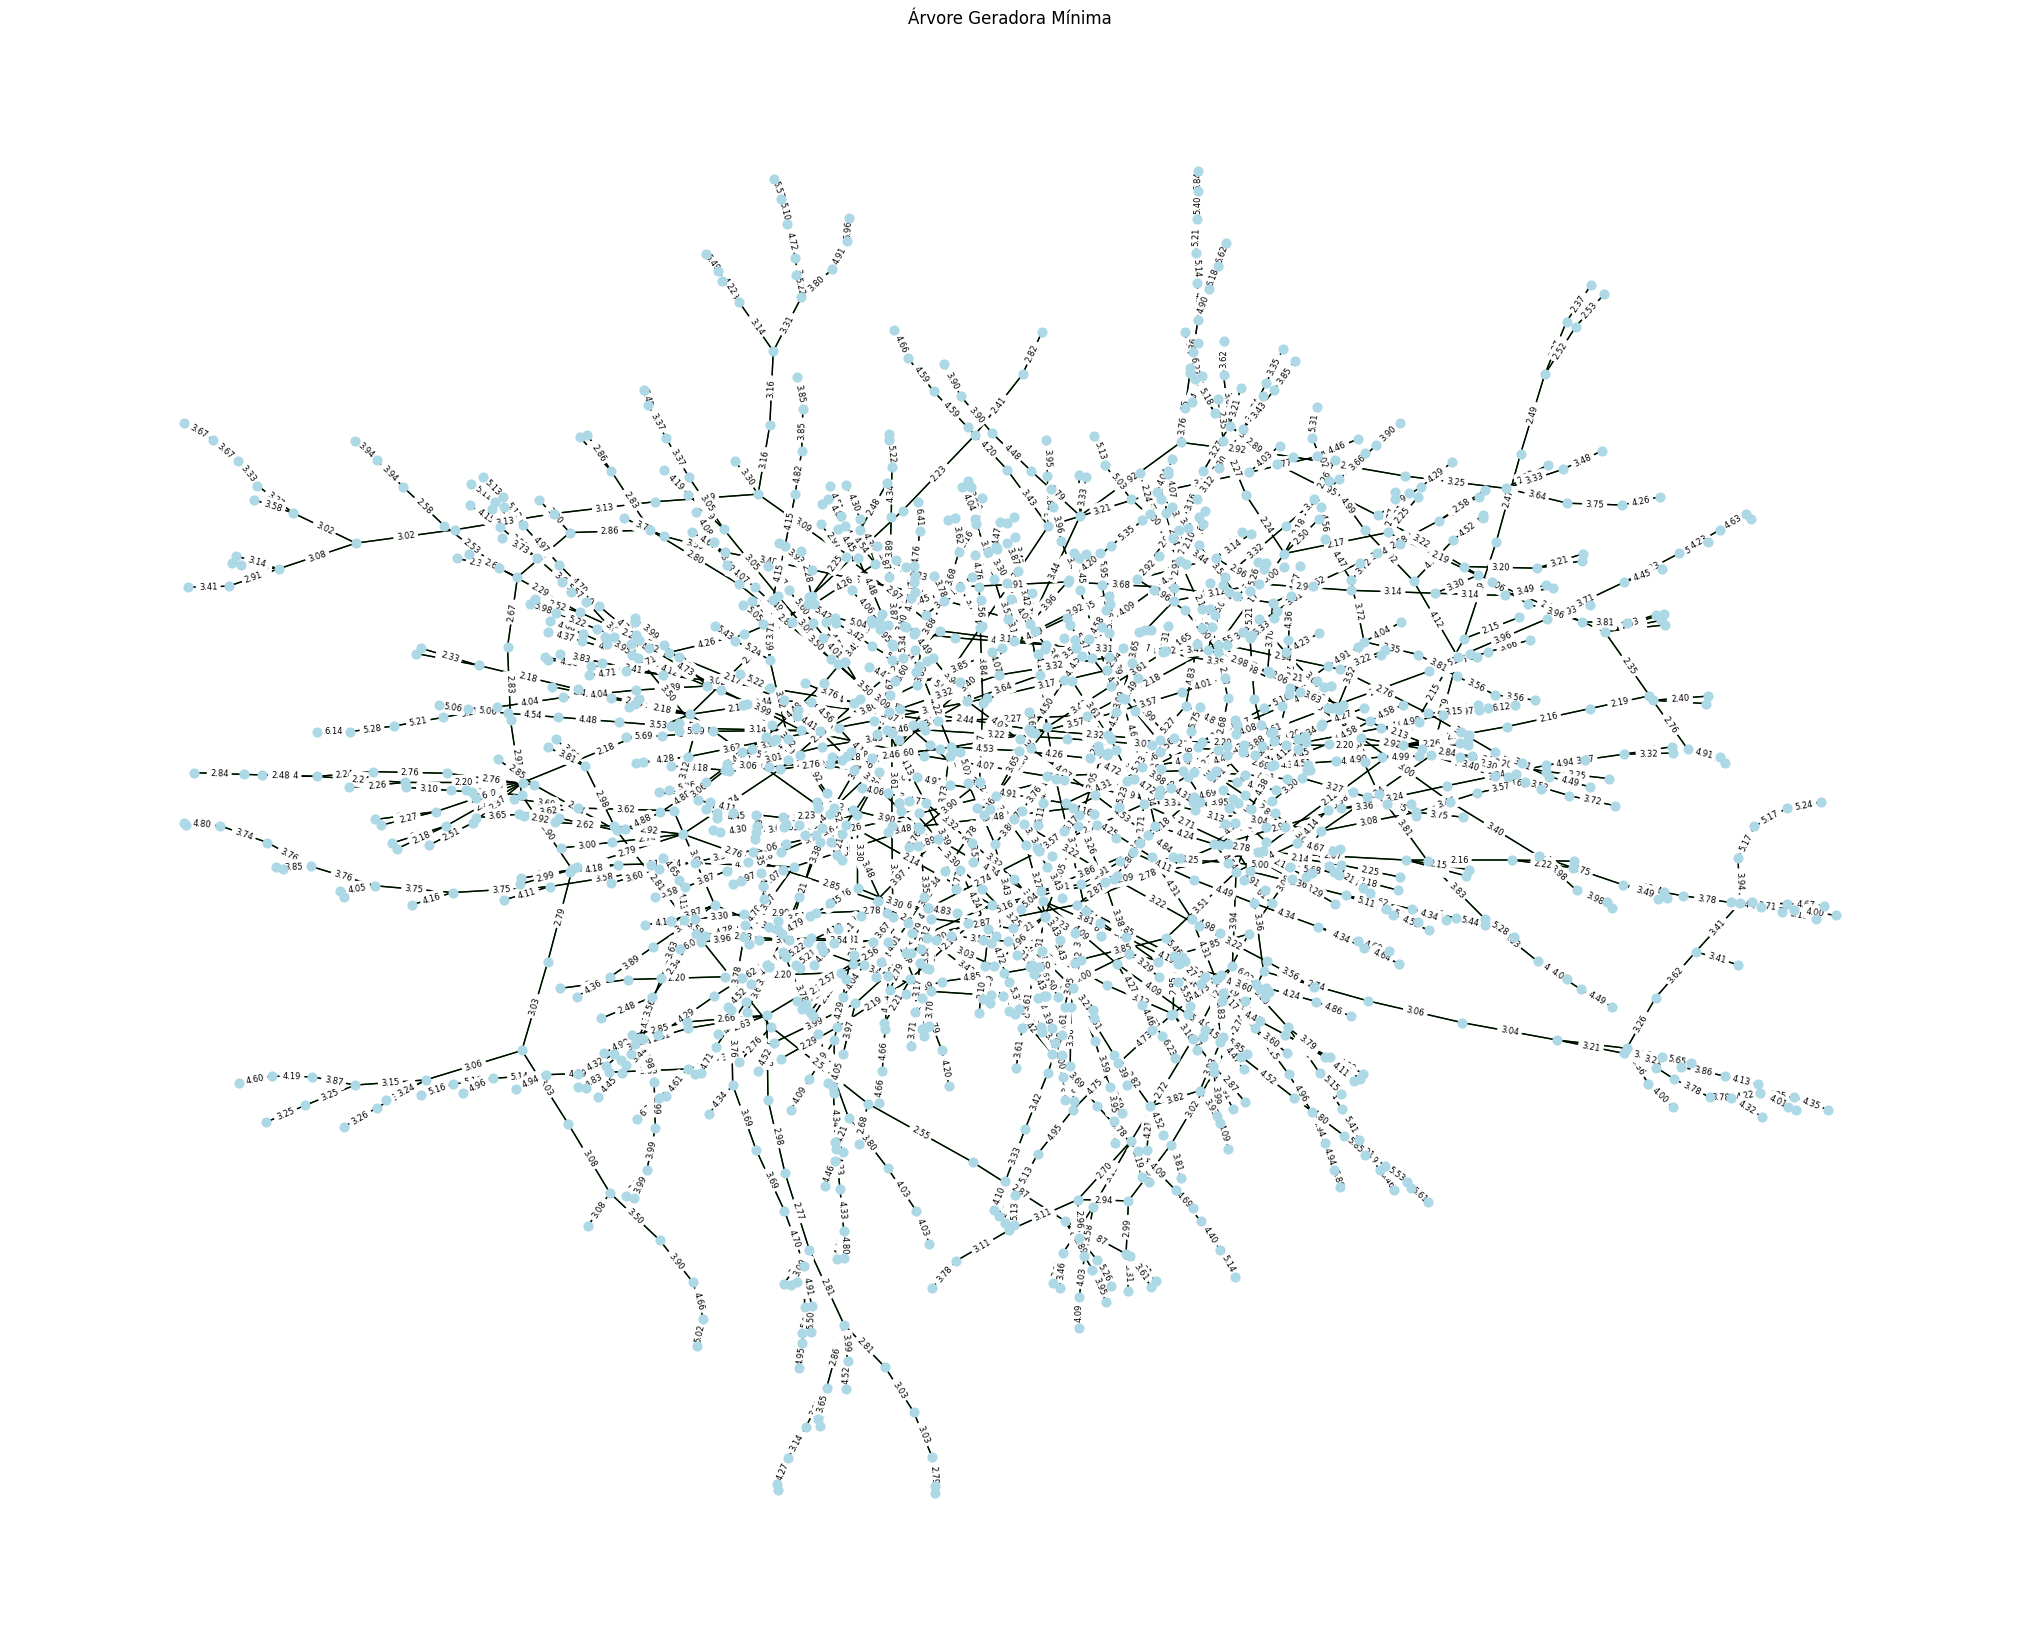

In [25]:
distancia_alcancabilidade_mutua = mutualReachabilityDistanceCalculation(datasetTreino)
reachability_graph = createReachabilityGraph(distancia_alcancabilidade_mutua)
mst = createMinimumSpanningTree(reachability_graph, True)

# 2) Difusão dos rótulos a partir do grafo

Recebendo a MST do primeiro passo precisamos usar todos esses métodos:
* GRF (Gaussian Random Fields)
* LGC (Local and GLobal Consistency)
* LapRLS (Laplacian Regularized Least Squares)
* LapSVM (Laplacian Support Vector Machine)
* RMGT (Robust Multi-class Graph Transductio)

In [26]:
# Função para possíveis atribuições ao dataset

def assignProperties(datasetToAssignLabel, labelArray, numberOfLabels=10, assignId=False):
    labels = np.where(labelArray == -1, 0, labelArray)
    random_indices = np.random.choice(len(datasetToAssignLabel), numberOfLabels, replace=False)
    datasetToAssignLabel['y'] = -1
    datasetToAssignLabel.loc[random_indices, 'y'] = labels[random_indices]
    if assignId:
        datasetToAssignLabel['ID'] = range(len(datasetToAssignLabel))
    return random_indices, datasetToAssignLabel


In [27]:
datasetTreino = pd.DataFrame(datasetTreino)
preLabeledIds, datasetWithLabelsAssigned = assignProperties(datasetTreino, datasets['USPS']['target'], 10, True)
datasetWithLabelsAssigned.head()

,0,1,2,3,4,5,6,7,8,9,...,233,234,235,236,237,238,239,240,y,ID
0,-0.333139,0.216292,0.362428,0.771932,0.347455,2.252831,-2.218989,-0.353117,1.572303,-0.111370,...,0.456282,0.261414,-0.172068,-0.128750,-1.164930,0.180035,0.321902,0.751093,-1,0
1,-0.367575,-0.461877,0.607720,0.434576,-0.462258,2.119836,-1.875407,-0.757397,1.394510,0.502064,...,0.076980,0.142799,-0.377307,-0.359275,-1.176700,0.095886,-0.272386,0.606542,-1,1
2,-0.485594,-0.127017,0.650853,0.351014,-0.510311,2.180026,-1.975940,-0.653218,1.325491,0.660739,...,-0.135087,-0.326631,-0.405666,-0.199507,-1.105598,0.083581,0.106733,0.611589,-1,2
3,-0.509527,0.066889,0.288846,1.735161,-0.069875,1.984327,-2.027574,-0.403721,1.516568,0.509582,...,1.370156,0.921805,-0.436169,0.050699,-1.159638,0.063271,-0.197991,0.773970,-1,3
4,-0.570235,0.060490,-0.266059,0.683626,0.103982,2.269077,-2.036760,-0.502954,1.598877,-0.292478,...,1.171063,0.759126,-0.169307,0.407567,-1.301980,0.126818,-0.796995,0.523336,-1,4
